In [1]:
import copy
import pathlib
import os.path
import json
import hashlib
import itertools
from typing import Any, Sequence, Mapping, Set

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

2024-06-04 16:11:38.675634: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 16:11:38.744578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 16:11:38.746330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 16:11:40.302704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
from rlplg import envsuite
from daaf import estimator_metrics

In [5]:
ENVS_MAPPING = {
    (
        "IceWorld",
        "4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64JMEBETNDXFFPYWTQJF46S5BJ4NXXCHNMJSLII3ROYXI76DFOC3VAABGNVA=",
    ): {"args": '{"map_name": "4x4"}', "name": "4x4"},
    ("ABCSeq", "10"): {
        "args": '{"length": 10, "distance_penalty": false}',
        "name": "n=10",
    },
    (
        "RedGreenSeq",
        "NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJEZOYLTSLB4ID4WHQG57XQPNUHGZCFDCWHYGXWSBW7FBWYRZGAGBW4J7MEQ=",
    ): {
        "args": '{"cure": ["red", "green", "wait", "green", "red", "red", "green", "wait"]}',
        "name": "n=9",
    },
    (
        "FrozenLake-v1",
        "U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I=",
    ): {"args": '{"is_slippery": false, "map_name": "4x4"}', "name": "4x4"},
    ("TowerOfHanoi", "4"): {"args": '{"num_disks": 4}', "name": "disks=4"},
    ("ABCSeq", "7"): {
        "args": '{"length": 7, "distance_penalty": false}',
        "name": "n=7",
    },
    (
        "IceWorld",
        "JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUAK5VNQ4KE45QZINGYFU5GR6D7F3GJMW7EC4TAY5PHCYRN5GPGP7YNACHEI=",
    ): {"args": '{"map_name": "8x8"}', "name": "8x8"},
    (
        "GridWorld",
        "P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3GQZSLKURMS2SRPEUF6O65F3ETJXEFNTR3UYS73TUCIIU3YIONXHAR6WE5A=",
    ): {
        "args": '{"grid": "oooooooooooo\\noooooooooooo\\noooooooooooo\\nsxxxxxxxxxxg"}',
        "name": "4x12",
    },
}

In [6]:
EXCLUDED_ENVS = set(["FrozenLake-v1"])

## Load Data

In [7]:
def read_data(paths: Sequence[str]) -> pd.DataFrame:
    dfs = []
    for path in paths:
        dfs.append(
            pd.read_json(path, lines=True)
        )
    return pd.concat(dfs)

In [8]:
def get_env_level(env_spec):
    loaded_env_spec = envsuite.load(env_spec["name"], **env_spec["args"])
    return loaded_env_spec.level
    # return hashlib.sha512(json.dumps(env_spec, sort_keys=True).encode()).hexdigest()

In [9]:
def proc_data(df_raw: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for row in df_raw.to_dict("records"):
        new_row = copy.deepcopy(row)
        result = new_row["result"]
        del new_row["result"]
        for key, value in result.items():
            new_row[key] = value

        # some arguments are populated to create a schema;
        # remove them.
        args_to_drop = set([key for key, value in new_row["env_spec"]["args"].items() if value is None])
        for arg in tuple(new_row["env_spec"]["args"].keys()):
            if arg in args_to_drop:
                del new_row["env_spec"]["args"][arg]
            else:
                # fix coerced types
                if isinstance(new_row["env_spec"]["args"][arg], float):
                    new_row["env_spec"]["args"][arg] = int(new_row["env_spec"]["args"][arg])
        # add env id;
        new_row["env_name"] = new_row["env_spec"]["name"]
        new_row["env_level"] = get_env_level(new_row["env_spec"])
        eid = (new_row["env_spec"]["name"], new_row["env_level"])
        new_row["env_label"] = ENVS_MAPPING[eid]["name"]
        rows.append(new_row)
    return pd.DataFrame(rows)  

In [10]:
df_raw = read_data(
        tf.io.gfile.glob(os.path.join(str(pathlib.Path.home()), "fs/daaf/exp/reward-estjob/logs/1717436262/*.json"))
    )

In [11]:
df_raw

,result,uid,spec,run_id,reward_period,accuracy,max_episodes,log_episode_frequency
0,"{'env_spec': {'args': {'map_name': '8x8'}, 'na...",97c861eb-a4e5-4d17-b084-89c7ff819d0b,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",16,6,1.000000e-08,7500,100
1,"{'env_spec': {'args': {'map_name': '8x8'}, 'na...",63690c77-65da-42f2-9bb1-71b41c0026ac,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",15,6,1.000000e-08,7500,100
2,"{'env_spec': {'args': {'map_name': '4x4'}, 'na...",09c45b48-c5e2-440d-8d97-aa988add9518,"{'args': {'map_name': '4x4'}, 'name': 'IceWorld'}",14,8,1.000000e-08,7500,100
0,"{'env_spec': {'args': {'map_name': '8x8'}, 'na...",c88aca57-a280-4ce2-b744-107a8d7c7761,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",18,4,1.000000e-08,7500,100
1,"{'env_spec': {'args': {'map_name': '4x4'}, 'na...",befdd7b5-03f5-4e11-bc76-e7595d511569,"{'args': {'map_name': '4x4'}, 'name': 'IceWorld'}",19,8,1.000000e-08,7500,100
...,...,...,...,...,...,...,...,...
2,{'env_spec': {'args': {'distance_penalty': Fal...,b60cacbf-ff49-4133-99cc-c412e739ef6a,"{'args': {'distance_penalty': False, 'length':...",19,4,1.000000e-08,7500,100
3,{'env_spec': {'args': {'distance_penalty': Fal...,22721746-06fd-491a-b4f7-782c2497196c,"{'args': {'distance_penalty': False, 'length':...",18,4,1.000000e-08,7500,100
0,{'env_spec': {'args': {'grid': 'oooooooooooo o...,e451b685-90e4-47ec-aaa9-55a37e58d583,{'args': {'grid': 'oooooooooooo oooooooooooo o...,3,6,1.000000e-08,7500,100
1,"{'env_spec': {'args': {'grid': None, 'num_disk...",704f89e2-7ca8-4907-b6bd-db2d867683ee,"{'args': {'grid': None, 'num_disks': 4.0}, 'na...",19,2,1.000000e-08,7500,100


In [12]:
df_results = proc_data(df_raw)

In [13]:
df_results

,uid,spec,run_id,reward_period,accuracy,max_episodes,log_episode_frequency,env_spec,episodes,full_rank,least,meta,ols_em,samples,steps,env_name,env_level,env_label
0,97c861eb-a4e5-4d17-b084-89c7ff819d0b,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",16,6,1.000000e-08,7500,100,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",7500,False,None,"{'est_accuracy': 1e-08, 'max_episodes': 7500, ...",None,18853,245849,IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8
1,63690c77-65da-42f2-9bb1-71b41c0026ac,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",15,6,1.000000e-08,7500,100,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",7500,False,None,"{'est_accuracy': 1e-08, 'max_episodes': 7500, ...",None,19180,250276,IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8
2,09c45b48-c5e2-440d-8d97-aa988add9518,"{'args': {'map_name': '4x4'}, 'name': 'IceWorld'}",14,8,1.000000e-08,7500,100,"{'args': {'map_name': '4x4'}, 'name': 'IceWorld'}",4679,True,"[-0.9999991655, -1.0, -0.9999971390000001, -1....","{'est_accuracy': 1e-08, 'max_episodes': 7500, ...","[-0.9999986069000001, -0.9999913334, -0.999997...",1536,40822,IceWorld,4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64J...,4x4
3,c88aca57-a280-4ce2-b744-107a8d7c7761,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",18,4,1.000000e-08,7500,100,"{'args': {'map_name': '8x8'}, 'name': 'IceWorld'}",7500,False,None,"{'est_accuracy': 1e-08, 'max_episodes': 7500, ...",None,5984,249754,IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8
4,befdd7b5-03f5-4e11-bc76-e7595d511569,"{'args': {'map_name': '4x4'}, 'name': 'IceWorld'}",19,8,1.000000e-08,7500,100,"{'args': {'map_name': '4x4'}, 'name': 'IceWorld'}",3144,True,"[-0.9999976754000001, -0.9999976158, -0.999998...","{'est_accuracy': 1e-08, 'max_episodes': 7500, ...","[-0.9999969562000001, -0.9999923605000001, -1....",1095,26849,IceWorld,4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64J...,4x4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,b60cacbf-ff49-4133-99cc-c412e739ef6a,"{'args': {'distance_penalty': False, 'length':...",19,4,1.000000e-08,7500,100,"{'args': {'distance_penalty': False, 'length':...",66,True,"[-1.0, -0.9999997616, -0.9999999404000001, -1....","{'est_accuracy': 1e-08, 'max_episodes': 7500, ...","[-1.0000000078, -1.0000000035, -0.999999998300...",572,3523,ABCSeq,7,n=7
636,22721746-06fd-491a-b4f7-782c2497196c,"{'args': {'distance_penalty': False, 'length':...",18,4,1.000000e-08,7500,100,"{'args': {'distance_penalty': False, 'length':...",52,True,"[-0.9999999404000001, -1.0000004768, -0.999999...","{'est_accuracy': 1e-08, 'max_episodes': 7500, ...","[-0.9999999992, -0.9999999999, -0.999999999400...",488,2656,ABCSeq,7,n=7
637,e451b685-90e4-47ec-aaa9-55a37e58d583,{'args': {'grid': 'oooooooooooo oooooooooooo o...,3,6,1.000000e-08,7500,100,{'args': {'grid': 'oooooooooooo oooooooooooo o...,7,True,"[-1.0000004768, -0.9999951124, -1.0000034571, ...","{'est_accuracy': 1e-08, 'max_episodes': 7500, ...","[-1.0000000024, -0.9999999980000001, -0.999999...",2634,16590,GridWorld,P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3G...,4x12
638,704f89e2-7ca8-4907-b6bd-db2d867683ee,"{'args': {'grid': None, 'num_disks': 4.0}, 'na...",19,2,1.000000e-08,7500,100,"{'args': {'num_disks': 4}, 'name': 'TowerOfHan...",19,True,"[-1.0, -1.0000001192, -1.0000003576, -1.000000...","{'est_accuracy': 1e-08, 'max_episodes': 7500, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",2450,25068,TowerOfHanoi,4,disks=4


In [14]:
df_results.iloc[0]

uid                                   97c861eb-a4e5-4d17-b084-89c7ff819d0b
spec                     {'args': {'map_name': '8x8'}, 'name': 'IceWorld'}
run_id                                                                  16
reward_period                                                            6
accuracy                                                               0.0
max_episodes                                                          7500
log_episode_frequency                                                  100
env_spec                 {'args': {'map_name': '8x8'}, 'name': 'IceWorld'}
episodes                                                              7500
full_rank                                                            False
least                                                                 None
meta                     {'est_accuracy': 1e-08, 'max_episodes': 7500, ...
ols_em                                                                None
samples                  

## True Reward Fn

In [15]:
def get_dynamics(environment):
    try:
        return getattr(environment, "transition")
    except AttributeError:
        return getattr(environment, "P")

In [16]:
def extract_reward_fn(spec):
    env_spec = envsuite.load(name=spec["name"], **spec["args"])
    dynamics = env_spec.mdp.transition
    num_states = env_spec.mdp.env_desc.num_states
    num_actions = env_spec.mdp.env_desc.num_actions
    reward_m = np.ndarray(shape=(num_states, num_actions), dtype=np.float64)
    for state in range(num_states):
        for action in range(num_actions):
            # average over next possible states
            reward = 0.0
            for prob, next_state, actual_reward, terminated in dynamics[state][action]:
                reward += prob * actual_reward
            reward_m[state, action] = reward
    return reward_m

In [17]:
extract_reward_fn(spec={"name": "IceWorld", "args": {"map_name": "4x4"}})

array([[ -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1., -32.],
       [ -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1., -32.],
       [ -1., -32.,  -1.,  -1.],
       [  0.,   0.,   0.,   0.],
       [-32., -32.,  -1.,  -1.],
       [  0.,   0.,   0.,   0.],
       [ -1.,  -1.,  -1., -32.],
       [ -1.,  -1., -32.,  -1.],
       [ -1., -32.,  -1.,  -1.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [-32.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.],
       [  0.,   0.,   0.,   0.]])

In [18]:
def get_reward_functions(df_results: pd.DataFrame) -> Mapping[str, np.ndarray]:
    reward_fns = {}
    for row, rid in zip(df_results.to_dict("records"), itertools.count()):
        eid = (row["env_name"], row["env_level"])
        if eid not in reward_fns:
            reward_fns[eid] = extract_reward_fn(row["env_spec"])
    return reward_fns

In [19]:
reward_fns = get_reward_functions(df_results)

In [20]:
len(reward_fns)

8

## Reached Full Rank

First question we ask is - in how many runs did we reach full rank to estimate the reward function?

In [21]:
def calc_completion(df_results: pd.DataFrame) -> pd.DataFrame:
    df_raw = copy.deepcopy(df_results[["env_name", "env_level", "env_label", "reward_period", "full_rank"]])
    df_completion = df_raw.groupby(
        ["env_name", "env_level", "env_label", "reward_period"]
    ).agg({"full_rank": ["sum", "count"]}).reset_index()

    return pd.DataFrame({
        "env_name": df_completion["env_name"],
        "env_level": df_completion["env_level"],
        "env_label": df_completion["env_label"],
        "reward_period": df_completion["reward_period"], 
        "total": df_completion["full_rank"]["count"],
        "completed": df_completion["full_rank"]["sum"],        
    })


In [22]:
df_completion = calc_completion(df_results)

In [23]:
df_completion

,env_name,env_level,env_label,reward_period,total,completed
0,ABCSeq,10,n=10,2,20,20
1,ABCSeq,10,n=10,4,20,20
2,ABCSeq,10,n=10,6,20,20
3,ABCSeq,10,n=10,8,20,20
4,ABCSeq,7,n=7,2,20,20
5,ABCSeq,7,n=7,4,20,20
6,ABCSeq,7,n=7,6,20,20
7,ABCSeq,7,n=7,8,20,20
8,FrozenLake-v1,U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK...,4x4,2,20,20
9,FrozenLake-v1,U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK...,4x4,4,20,20


In [24]:
df_completion[["env_name", "env_label", "total", "completed"]].groupby(["env_name", "env_label"]).sum().reset_index()

,env_name,env_label,total,completed
0,ABCSeq,n=10,80,80
1,ABCSeq,n=7,80,80
2,FrozenLake-v1,4x4,80,76
3,GridWorld,4x12,80,80
4,IceWorld,4x4,80,77
5,IceWorld,8x8,80,0
6,RedGreenSeq,n=9,80,80
7,TowerOfHanoi,disks=4,80,80


## Time to Full Rank - By Episodes

In [25]:
def plot_time_till_fullrank(df_results: pd.DataFrame, metric: str, output_dir: str = "figures/tt_full_rank", exclude_envs: Set[str] = EXCLUDED_ENVS):
    df_raw = copy.deepcopy(
        df_results[df_results["full_rank"] == True][["env_name", "env_level", "env_label", "reward_period", metric]]
    )
    rows = []
    for row in df_raw.to_dict("records"):
        if row["env_name"] in exclude_envs:
            continue
        rows.append(
            {
                "eid": (row["env_name"],  row["env_label"]),
                **row
            }
        )
    df_proc = pd.DataFrame(rows)
    eids = sorted(df_proc["eid"].unique())
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)    
    fig, axes = plt.subplots(ncols=len(eids), figsize=(5 * len(eids), 5))
    for eid, ax in zip(eids, axes.flatten()):
        df_plot = df_proc[df_proc["eid"] == eid]
        metric_name = "".join([metric[0].upper(), metric[1:]])
        df_plot = df_plot.rename(
            {
            "eid": "Environment", 
            metric: metric_name,
            "reward_period": "Reward Period"
            },
            axis=1,
        )
        sns.boxplot(data=df_plot, x="Environment", y=metric_name, hue="Reward Period", ax=ax)
        sample_row = df_plot.iloc[0]
    fname = "".join([metric, ".pdf"])
    plt.savefig(os.path.join(output_dir, fname), format="pdf", dpi=300, transparent= True)
    

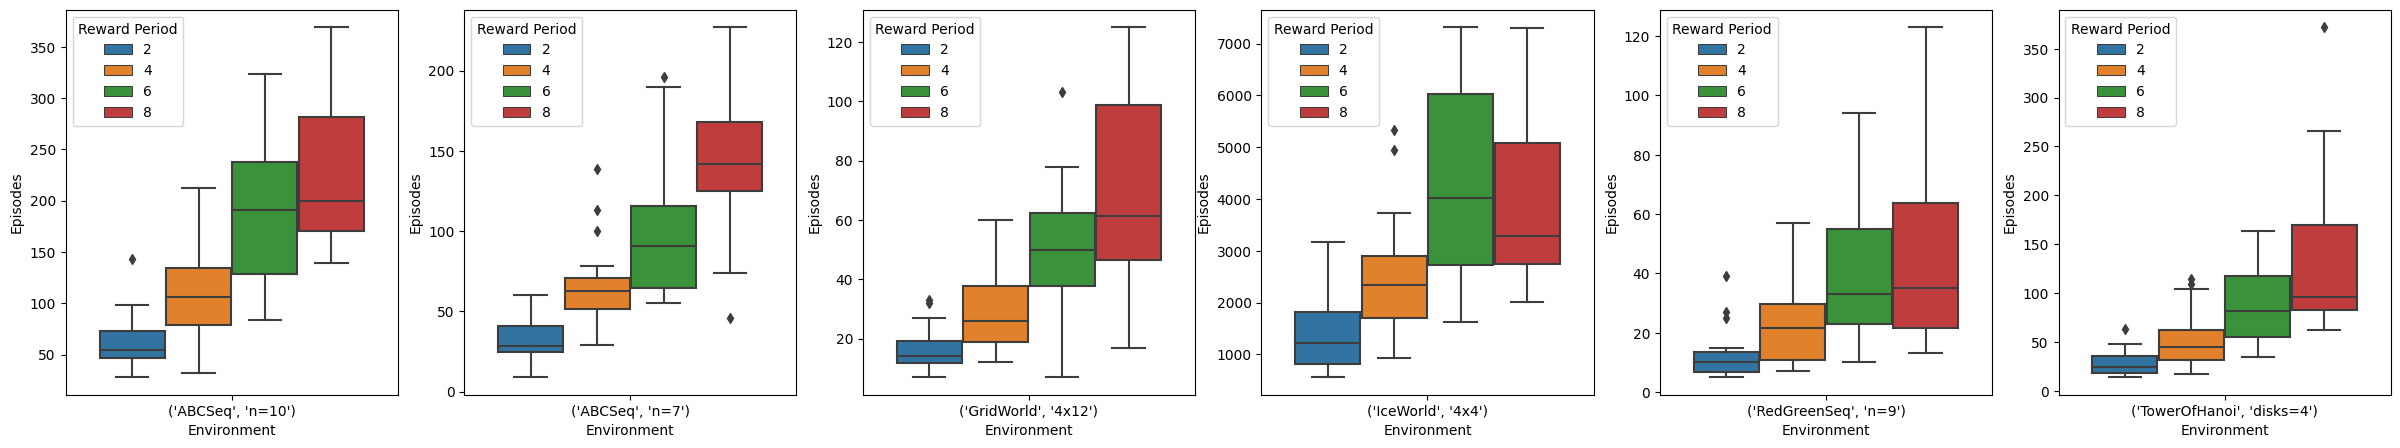

In [26]:
plot_time_till_fullrank(df_results, "episodes")

In [27]:
df_results.iloc[0]

uid                                   97c861eb-a4e5-4d17-b084-89c7ff819d0b
spec                     {'args': {'map_name': '8x8'}, 'name': 'IceWorld'}
run_id                                                                  16
reward_period                                                            6
accuracy                                                               0.0
max_episodes                                                          7500
log_episode_frequency                                                  100
env_spec                 {'args': {'map_name': '8x8'}, 'name': 'IceWorld'}
episodes                                                              7500
full_rank                                                            False
least                                                                 None
meta                     {'est_accuracy': 1e-08, 'max_episodes': 7500, ...
ols_em                                                                None
samples                  

## Time to Full Rank - By Steps

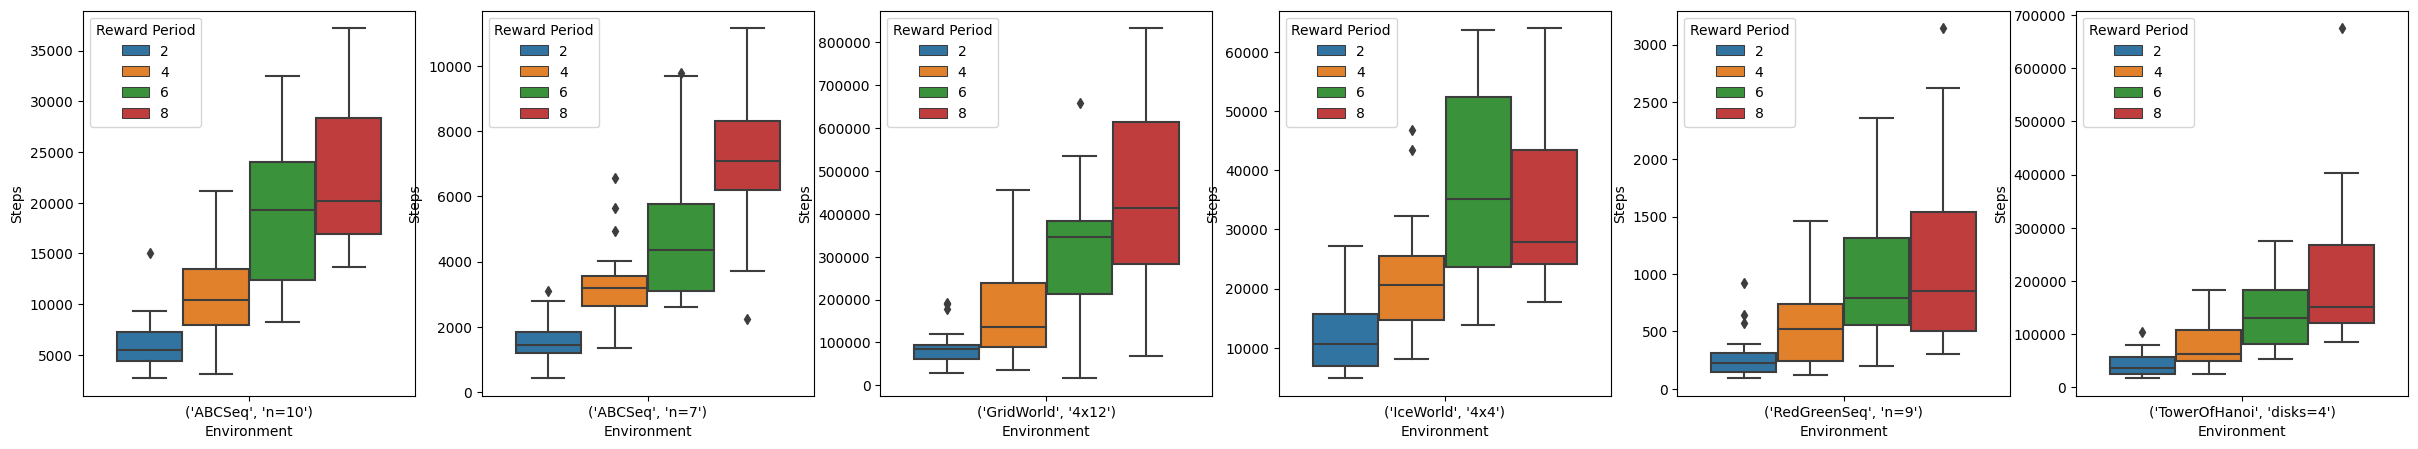

In [28]:
plot_time_till_fullrank(df_results, "steps")

## Estimation Error

What is the error in recovering the reward function/matrix?

In [29]:
def estimation_error(df_results: pd.DataFrame, reward_fns):
    def rmse(vpred, vtrue):
        return estimator_metrics.rmse(v_pred=vpred, v_true=vtrue, axis=0) if np.sum(np.isnan(vpred)) == 0 else None

    def equality(vpred, vtrue):
        return np.allclose(vpred, vtrue, atol=1e-02) if np.sum(np.isnan(vpred)) == 0 else None
    
    df_raw = copy.deepcopy(
        df_results[
            df_results["full_rank"]
        ][["env_name", "env_level", "env_label", "ols_em", "least", "reward_period"]]
    )
    rows = []
    for row in df_raw.to_dict("records"):
        eid = (row["env_name"],  row["env_level"])
        vtrue = reward_fns[eid].flatten()
        least = np.array(row["least"], dtype=np.float64)
        ols_em = np.array(row["ols_em"], dtype=np.float64)

        least_rmse = estimator_metrics.rmse(v_pred=least, v_true=vtrue, axis=0) if np.sum(np.isnan(least)) == 0 else None
        ols_em_rmse = estimator_metrics.rmse(v_pred=ols_em, v_true=vtrue, axis=0) if np.sum(np.isnan(ols_em)) == 0 else None
        
        rows.append(
            {
                "eid": (row["env_name"],  row["env_label"]),
                "rmse": {
                    "least": rmse(least, vtrue=vtrue),
                    "ols_em": rmse(ols_em, vtrue=vtrue),
                },
                "equality": {
                    "least": equality(least, vtrue=vtrue),
                    "ols_em": equality(ols_em, vtrue=vtrue),
                },
                **row
            }
        )
    df_proc = pd.DataFrame(rows)
    return df_proc

In [30]:
df_est_error = estimation_error(df_results, reward_fns)        

In [31]:
df_est_error

,eid,rmse,equality,env_name,env_level,env_label,ols_em,least,reward_period
0,"(IceWorld, 4x4)","{'least': 4.329769085554331e-06, 'ols_em': 0.0...","{'least': True, 'ols_em': True}",IceWorld,4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64J...,4x4,"[-0.9999986069000001, -0.9999913334, -0.999997...","[-0.9999991655, -1.0, -0.9999971390000001, -1....",8
1,"(IceWorld, 4x4)","{'least': 3.489962798833666e-06, 'ols_em': 0.0...","{'least': True, 'ols_em': True}",IceWorld,4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64J...,4x4,"[-0.9999969562000001, -0.9999923605000001, -1....","[-0.9999976754000001, -0.9999976158, -0.999998...",8
2,"(ABCSeq, n=10)","{'least': 2.7019107479257814e-07, 'ols_em': 9....","{'least': True, 'ols_em': True}",ABCSeq,10,n=10,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-0.9999995828, -0.9999998808, -0.9999998808, ...",4
3,"(FrozenLake-v1, 4x4)","{'least': 6.224058663765952e-09, 'ols_em': None}","{'least': True, 'ols_em': None}",FrozenLake-v1,U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK...,4x4,"[None, None, None, None, None, None, None, Non...","[0.0, -1e-10, 3e-10, -0.0, -2e-10, -7.00000000...",4
4,"(FrozenLake-v1, 4x4)","{'least': 1.5768684353807074e-08, 'ols_em': None}","{'least': True, 'ols_em': None}",FrozenLake-v1,U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK...,4x4,"[None, None, None, None, None, None, None, Non...","[0.0, -2e-10, 0.0, 0.0, 0.0, -1e-10, -4e-10, -...",4
...,...,...,...,...,...,...,...,...,...
548,"(ABCSeq, n=7)","{'least': 2.8766709739092067e-07, 'ols_em': 8....","{'least': True, 'ols_em': True}",ABCSeq,7,n=7,"[-1.0000000078, -1.0000000035, -0.999999998300...","[-1.0, -0.9999997616, -0.9999999404000001, -1....",4
549,"(ABCSeq, n=7)","{'least': 2.2109855388837518e-07, 'ols_em': 0....","{'least': True, 'ols_em': True}",ABCSeq,7,n=7,"[-0.9999999992, -0.9999999999, -0.999999999400...","[-0.9999999404000001, -1.0000004768, -0.999999...",4
550,"(GridWorld, 4x12)","{'least': 7.981217238835397e-06, 'ols_em': 0.0...","{'least': True, 'ols_em': True}",GridWorld,P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3G...,4x12,"[-1.0000000024, -0.9999999980000001, -0.999999...","[-1.0000004768, -0.9999951124, -1.0000034571, ...",6
551,"(TowerOfHanoi, disks=4)","{'least': 1.6294389866635117e-07, 'ols_em': 2....","{'least': True, 'ols_em': True}",TowerOfHanoi,4,disks=4,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0000001192, -1.0000003576, -1.000000...",2


### Convergence to result

How many times did each method arrive at a result?

In [32]:
def est_convergence(df_est_error: pd.DataFrame):
    df_raw = copy.deepcopy(
        df_est_error[["eid", "equality", "env_name", "env_label"]]
    )
    for est_method in ("least", "ols_em"):
        df_raw[est_method] = df_raw["equality"].apply(lambda eq: eq[est_method])
    del df_raw["equality"]
    return df_raw.groupby(["eid", "env_name", "env_label"]).agg({"least": ["sum", "count"], "ols_em": ["sum", "count"]}).reset_index()

In [33]:
df_est_conv = est_convergence(df_est_error)

In [34]:
df_est_conv

eid       env_name env_label least       ols_em      
                                                      sum count    sum count
0           (ABCSeq, n=10)         ABCSeq      n=10    80    80     80    80
1            (ABCSeq, n=7)         ABCSeq       n=7    80    80     80    80
2     (FrozenLake-v1, 4x4)  FrozenLake-v1       4x4    75    76      0     0
3        (GridWorld, 4x12)      GridWorld      4x12    80    80     80    80
4          (IceWorld, 4x4)       IceWorld       4x4    76    77     76    77
5       (RedGreenSeq, n=9)    RedGreenSeq       n=9    77    80     77    80
6  (TowerOfHanoi, disks=4)   TowerOfHanoi   disks=4    80    80     80    80

### Error plots

In [35]:
def plot_est_error(df_est_error: pd.DataFrame, exclude_envs: Set[str] = EXCLUDED_ENVS, output_dir: str = "figures/est_error"):
    from matplotlib import ticker
    mask = df_est_error["env_name"].apply(lambda env: env not in exclude_envs)
    df_raw = copy.deepcopy(
        df_est_error[mask][["eid", "env_name", "env_level", "env_name", "rmse", "reward_period"]]
    )
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    est_methods = sorted(["least", "ols_em"])
    for row, est_method in enumerate(est_methods):
        print(est_method)
        df_est_method = copy.deepcopy(df_raw)
        df_est_method["rmse"] = df_est_method["rmse"].apply(lambda entry: entry[est_method])
        df_est_method = df_est_method[~np.isnan(df_est_method["rmse"])]
        eids = sorted(df_est_method["eid"].unique())
        fig, axes = plt.subplots(ncols=len(eids), figsize=(5 * len(eids), 5))
        for eid, ax in zip(eids, axes.flatten()):
            df_plot = copy.deepcopy(df_est_method[df_est_method["eid"] == eid])
            df_plot = df_plot.rename(
                {
                "eid": "Environment", 
                "rmse": "RMSE",
                "reward_period": "Reward Period"
                },
                axis=1,
            )            
            sns.boxplot(data=df_plot, x="Environment", y="RMSE", hue="Reward Period", ax=ax)
            ax.ticklabel_format(axis="y", style='sci', scilimits=(0,0))
        fname = "".join([est_method, ".pdf"])
        fig.savefig(os.path.join(output_dir, fname), format="pdf", dpi=300, transparent=True, bbox_inches="tight",)   

least
ols_em


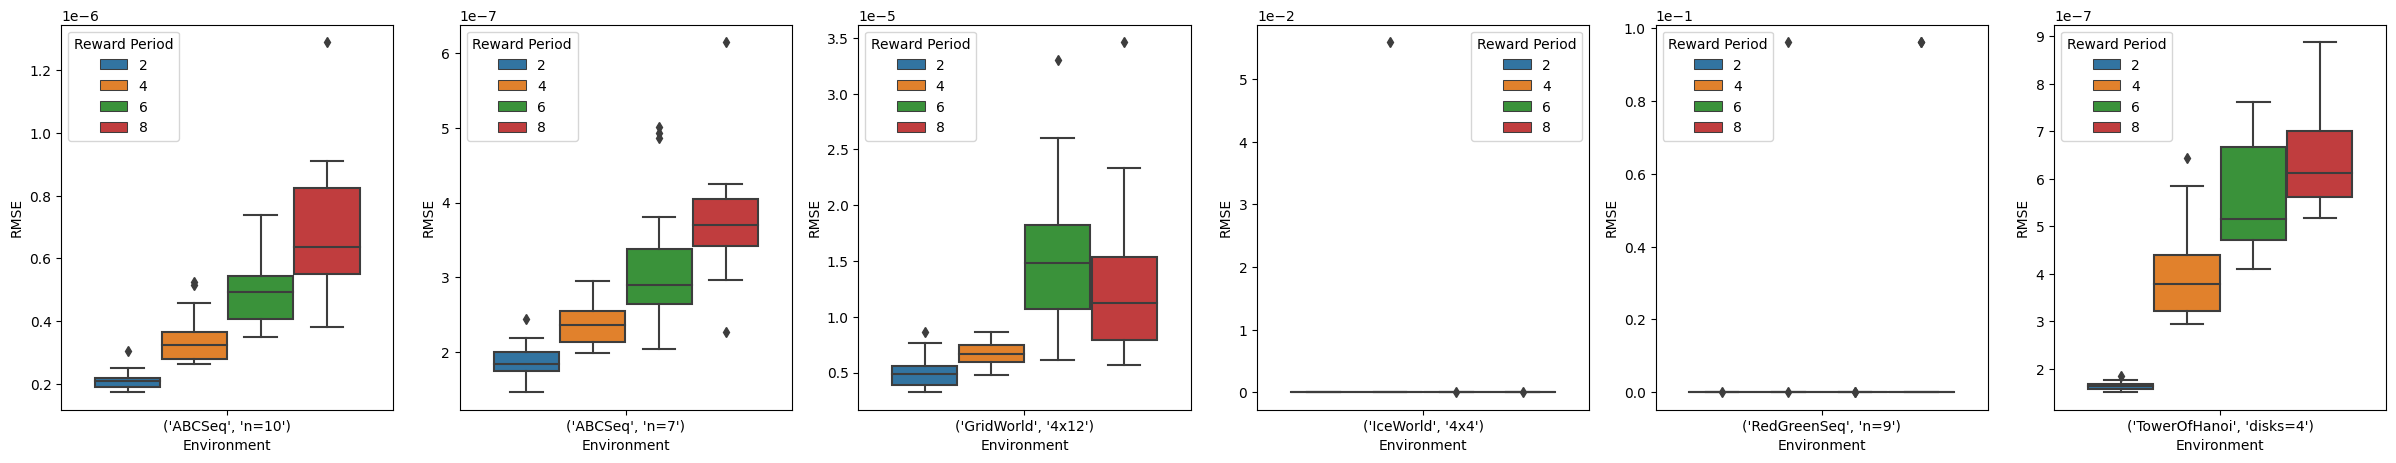

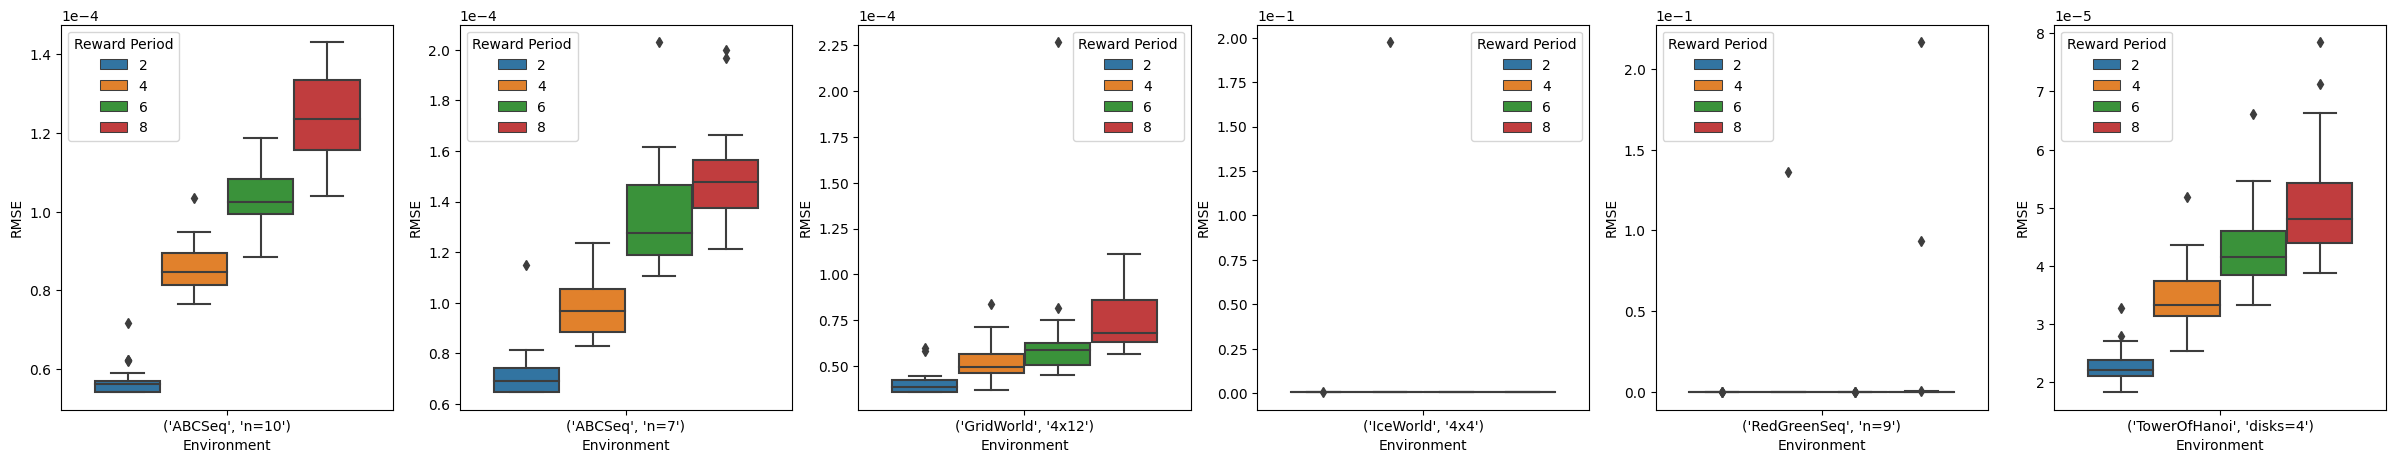

In [36]:
plot_est_error(df_est_error)